In [18]:
!pip install toolz

from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

np.set_printoptions(suppress=True)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from toolz import memoize

## Nearest Neighbor Classifier (Review)

In [2]:
patients = Table.read_table('http://inferentialthinking.com/notebooks/breast-cancer.csv').drop('ID')
patients.show(5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0


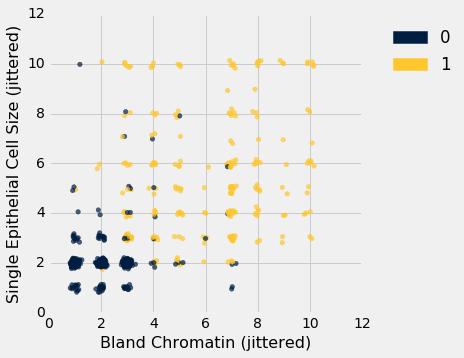

In [3]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = Table().with_columns([
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class',
        patients.column('Class')
    ])

jittered.scatter(0, 1, colors='Class')

In [4]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))

In [5]:
def distances(training, example):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop('Class')
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    return training.with_column('Distance', dists)

def closest(training, example, k):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example).sort('Distance').take(np.arange(k))

def majority_class(top_k):
    """Return the class with the highest count."""
    return top_k.group('Class').sort('count', descending=True).column(0).item(0)

def classify(training, example, k):
    """Return the majority class among the k nearest neighbors."""
    return majority_class(closest(training, example, k))

In [6]:
patients.take(12)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,3,3,3,2,3,4,4,1,1


In [7]:
example = patients.drop('Class').row(12)
example

Row(Clump Thickness=5, Uniformity of Cell Size=3, Uniformity of Cell Shape=3, Marginal Adhesion=3, Single Epithelial Cell Size=2, Bare Nuclei=3, Bland Chromatin=4, Normal Nucleoli=4, Mitoses=1)

In [8]:
classify(patients.exclude(12), example, 5)

0

## Evaluation

In [9]:
patients.num_rows

683

In [10]:
shuffled = patients.sample(with_replacement=False) # Randomly permute the rows
trainset = shuffled.take(range(342))
testset  = shuffled.take(range(342, 683))

In [11]:
def evaluate_accuracy(training, test, k):
    test_attributes = test.drop('Class')
    numcorrect = 0
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = classify(training, test_attributes.row(i), k)
        # Was the classifier's prediction correct?
        if c == test.column('Class').item(i):
            numcorrect = numcorrect + 1
    return numcorrect / test.num_rows

In [57]:
def plot_test_point(n):
    trainset.scatter(0, 1, colors='Class')
    point = testset.row(n)
    print('Original class:', point.item('Class'))
    plt.scatter(point.item(0) + 0.2, point.item(1) + 0.2, c='red', s=100)
    plt.show()
    
_ = interact(plot_test_point, n=101)

In [12]:
evaluate_accuracy(trainset, testset, 1)

0.967741935483871

In [13]:
evaluate_accuracy(trainset, testset, 3)

0.9736070381231672

In [14]:
evaluate_accuracy(trainset, testset, 5)

0.9794721407624634

Discussion question: What is the accuracy of 1-NN on the training set?

In [15]:
evaluate_accuracy(trainset, trainset, 1)

1.0

## Decision boundaries

In [19]:
ckd = Table.read_table('http://inferentialthinking.com/notebooks/ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.show(3)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1


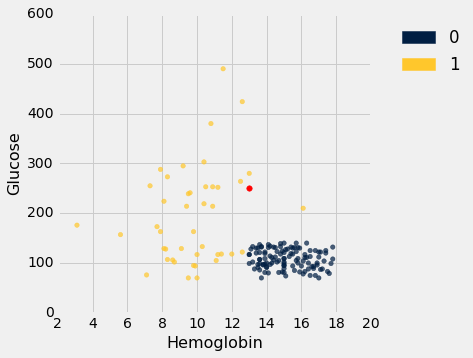

In [20]:
kidney = ckd.select('Hemoglobin', 'Glucose', 'Class')
kidney.scatter(0, 1, colors=2)
plt.scatter(13, 250, color='red', s=30)

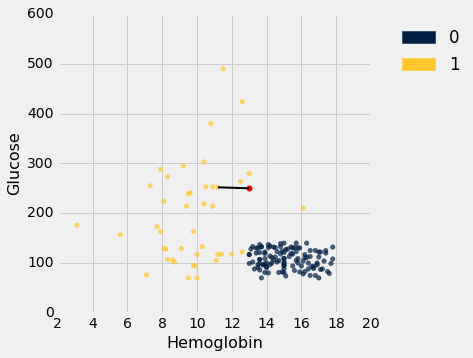

In [21]:
def show_closest(t, point):
    """Show closest training example to a point."""
    near = closest(t, point, 1).row(0)
    t.scatter(0, 1, colors='Class')
    plt.scatter(point.item(0), point.item(1), color='red', s=30)
    plt.plot([point.item(0), near.item(0)], [point.item(1), near.item(1)], color='k', lw=2)

show_closest(kidney, make_array(13, 250))

In [22]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)  

def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

In [23]:
kidney_su = standardize(kidney.drop('Class')).with_column('Class', kidney.column('Class'))

def show_closest_y(y=1.8):
    show_closest(kidney_su, make_array(-0.2, y))
    plt.show()

_ = interact(show_closest_y, y=(0.9, 1.8, 0.05))

Widget Javascript not detected.  It may not be installed or enabled properly.


In [24]:
# Memoize this cause it takes a while.
# With this, we can create an interactive demo. Make sure to run this cell
# before lecture! It takes quite a while.
@memoize(key=lambda args, kwargs: (id(args[0]), args[1]))
def decisions(t, k):
    t_su = standardize(t.drop('Class')).with_column('Class', t.column('Class'))
    result = Table(t_su.labels)
    for x in np.arange(-2, 2.1, 0.1):
        for y in np.arange(-2, 2.1, 0.1):
            predicted = classify(t_su, make_array(x, y), k)
            result.append([x, y, predicted])
    return result

def decision_boundary(t, k=1):
    """Decision boundary of a two-column + Class table."""
    ds = decisions(t, k)
    ds.scatter(0, 1, colors='Class', alpha=0.4)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    t_su = standardize(t.drop('Class')).with_column('Class', t.column('Class'))
    t_su_0 = t_su.where('Class', 0)
    t_su_1 = t_su.where('Class', 1)
    plt.scatter(t_su_0.column(0), t_su_0.column(1), c='darkblue', edgecolor='k')
    plt.scatter(t_su_1.column(0), t_su_1.column(1), c='gold', edgecolor='k')
    plt.show()
    
decisions(kidney, 1)
decisions(kidney, 3)
decisions(kidney, 5)
decisions(kidney, 7)
decisions(jittered, 1)
decisions(jittered, 3)
decisions(jittered, 5)
decisions(jittered, 7)
None

In [58]:
_ = interact(decision_boundary, t=fixed(kidney), k=(1, 7, 2))

Discussion question: Why do the decision boundaries change?

In [59]:
_ = interact(decision_boundary, t=fixed(jittered), k=(1, 7, 2))

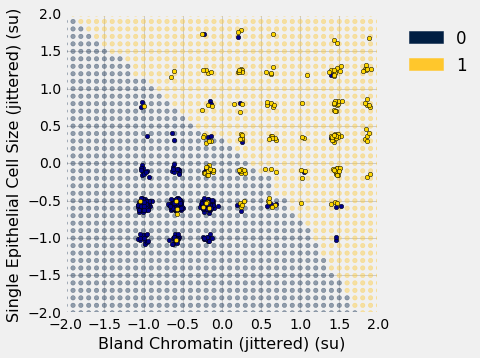

In [60]:
decision_boundary(jittered, 101)